# Malaria classification

In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imsave, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
import sklearn.metrics as metrics

import keras
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.layers import CuDNNLSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils.np_utils import to_categorical
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity

#K.set_image_dim_ordering('tf')
plt.rcParams['image.cmap'] = 'gray'
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

Using TensorFlow backend.


## Malaria Classification

We will design and train a neural network to detect whether or not a cell is infected with malaria.

The data can be found in: 
- './Data/Malaria/train/infected/': images of malaria infected cells used for training purposes.
- './Data/Malaria/train/uninfected/': images of healthy cells used for training purposes.
- './Data/Malaria/test/infected/': images of malaria infected cells used for testing purposes
- './Data/Malaria/test/uninfected/': images of healthy cells used for testing purposes 

First we will train and evaluate our own convolutional neural network. Then we will apply transfer learning by means of VGG19.



In [3]:
# Read and preprocess images

image_size = 100
nr_train_images = 1000
nr_test_images = 1000
infected_train_images = []
infected_test_images = []
uninfected_train_images = []
uninfected_test_images = []
y_infected_train = []
y_uninfected_train = []
y_infected_test = []
y_uninfected_test =[]

# read infected train_images
path = './Data/Malaria/train/infected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_train_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    infected_train_images.append(im)
    y_infected_train.append(1)
    
# read infected test_images

path = './Data/Malaria/test/infected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_test_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f))
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    infected_test_images.append(im)
    y_infected_test.append(1)
    

# read uninfected train_images
path = './Data/Malaria/train/uninfected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_train_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    uninfected_train_images.append(im)
    y_uninfected_train.append(0)


# read uninfected test_images

path = './Data/Malaria/test/uninfected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_test_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    uninfected_test_images.append(im)
    y_uninfected_test.append(0)
    


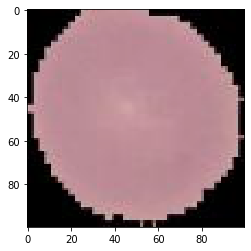

In [4]:
plt.imshow(uninfected_train_images[0])

In [18]:
# compile training set and test set
    
X_train = np.vstack((np.asarray(infected_train_images),np.asarray(uninfected_train_images)))

X_test = np.vstack((np.asarray(infected_test_images),np.asarray(uninfected_test_images)))

y_train = np.hstack((np.asarray(y_infected_train),np.asarray(y_uninfected_train)))

y_test = np.hstack((np.asarray(y_infected_test),np.asarray(y_uninfected_test)))

# randomize training set
X_train, y_train = shuffle(X_train, y_train, random_state=0)

# randomize test set
X_test, y_test = shuffle(X_test,y_test, random_state=0)

In [19]:
# Image normalization

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

# One-hot-encoding of the output labels
y_train = np_utils.to_categorical(y_train)

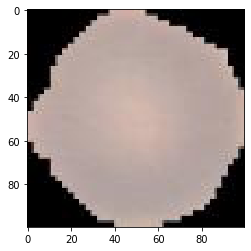

In [20]:
plt.imshow(X_train[10])

In [22]:
# Neural network parameters
#-----------------------------------------------
#-----------------------------------------------
batch_size = 16
epochs = 10
#-----------------------------------------------
#-----------------------------------------------
num_classes = 2
img_rows, img_cols = image_size, image_size
input_shape = (img_rows, img_cols,3)

# Model
model = Sequential()
#-----------------------------------------------
#-----------------------------------------------
model.add(Conv2D(64, kernel_size=(3, 3),  
                 activation='relu',
                 input_shape=input_shape)) 
#-----------------------------------------------
#-----------------------------------------------
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
model.add(Dropout(0.1)) 
model.add(BatchNormalization())
#-----------------------------------------------
#-----------------------------------------------
model.add(Conv2D(64, kernel_size=(3, 3),  
                 activation='relu',
                 input_shape=input_shape)) 
#-----------------------------------------------
#-----------------------------------------------
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
model.add(Dropout(0.1)) 
model.add(BatchNormalization())
#-----------------------------------------------
model.add(Conv2D(64, (3, 3), activation='relu')) 
#-----------------------------------------------
#-----------------------------------------------
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
#-----------------------------------------------
model.add(Dropout(0.1)) 
model.add(BatchNormalization())
#-----------------------------------------------
#-----------------------------------------------
model.add(Flatten()) 
model.add(Dense(10, activation='relu'))
#-----------------------------------------------
#-----------------------------------------------
model.add(Dropout(0.1)) 
model.add(BatchNormalization())
#-----------------------------------------------
#-----------------------------------------------
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# Train the CNN
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/10
2000/2000 [==============================] - 91s 45ms/step - loss: 0.7521 - acc: 0.6095
Epoch 2/10
2000/2000 [==============================] - 91s 45ms/step - loss: 0.6589 - acc: 0.6365
Epoch 3/10
2000/2000 [==============================] - 92s 46ms/step - loss: 0.5401 - acc: 0.7340
Epoch 4/10
2000/2000 [==============================] - 92s 46ms/step - loss: 0.3643 - acc: 0.8515
Epoch 5/10
2000/2000 [==============================] - 92s 46ms/step - loss: 0.2989 - acc: 0.8845
Epoch 6/10
2000/2000 [==============================] - 99s 49ms/step - loss: 0.2387 - acc: 0.9075
Epoch 7/10
2000/2000 [==============================] - 96s 48ms/step - loss: 0.2065 - acc: 0.9185
Epoch 8/10
2000/2000 [==============================] - 96s 48ms/step - loss: 0.1914 - acc: 0.9265
Epoch 9/10
2000/2000 [==============================] - 94s 47ms/step - loss: 0.1532 - acc: 0.9450
Epoch 10/10
2000/2000 [==============================] - 100s 50ms/step - loss: 0.1397 - acc: 0.9435




accuracy score: 91.23333333333333


              precision    recall  f1-score   support

           0       0.89      0.94      0.92      3000
           1       0.94      0.88      0.91      3000

   micro avg       0.91      0.91      0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000

[[2833  167]
 [ 359 2641]]


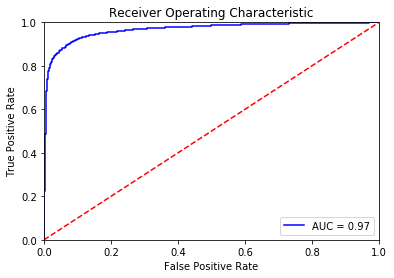

In [11]:
# Testing the neural network

y_pred = model.predict_classes(X_test)
probs = model.predict_proba(X_test)
print('\n')
print('accuracy score:', accuracy_score(y_test, y_pred) * 100)
print('\n')
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)
print(cf)

# ROC

# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



## Transfer learing with VGG19

In [12]:
modelVGG19 = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(100,100,3))
type(modelVGG19)

# Convert to sequential model
model = Sequential()

for layer in modelVGG19.layers[:]:
    model.add(layer)
    
# Make weights fixed
for layer in model.layers:
    layer.trainable = False

# Adding dense layers
model.add(Flatten()) 
model.add(Dense(10,activation='sigmoid'))
model.add(Dense(2,activation='sigmoid'))    
model.summary()


adam = keras.optimizers.adam()
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 25, 25, 256)       295168    
__________

In [13]:
# retrain the VGG model

batch_size =16
epochs = 4

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/4
2000/2000 [==============================] - 66s 33ms/step - loss: 0.5512 - acc: 0.7700
Epoch 2/4
2000/2000 [==============================] - 67s 34ms/step - loss: 0.4435 - acc: 0.8700
Epoch 3/4
2000/2000 [==============================] - 68s 34ms/step - loss: 0.3913 - acc: 0.8925
Epoch 4/4
2000/2000 [==============================] - 69s 34ms/step - loss: 0.3459 - acc: 0.9050




accuracy score: 90.8


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1000
           1       0.92      0.89      0.91      1000

   micro avg       0.91      0.91      0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

[[926  74]
 [110 890]]


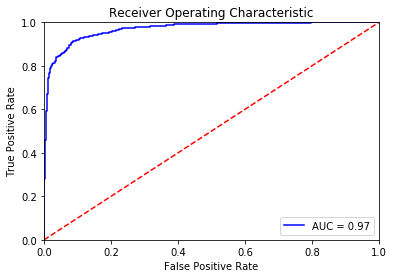

In [29]:
# Testing the VGG network

# Testing the neural network

y_pred = model.predict_classes(X_test)
probs = model.predict_proba(X_test)
print('\n')
print('accuracy score:', accuracy_score(y_test, y_pred) * 100)
print('\n')
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)
print(cf)

# ROC

# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
